In [7]:
import pandas as pd
import os
import os.path
import re
import sys
import codecs
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')
import numpy as np # linear algebra
import pandas as pd
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\24596\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\24596\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\24596\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\24596\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
df = pd.read_json("data_train.json",encoding="utf-8", orient='records',lines=True)
df=df.iloc[:1000,:]

### 预处理

In [16]:
lemmatizer = WordNetLemmatizer()
#删除url 统一资源定位符
def rmURL(line):
    import re
    pattern = re.compile(r'http[a-zA-Z0-9.?/&=:]*')
    return pattern.sub('', line.strip())

# 去非中文、英文、数字字符， 如表情，小语种字符
def rmUNK(line):
    import re
    pattern = re.compile(u'[^0-9a-zA-Z\u4e00-\u9fa5.，,。？“”]+', re.UNICODE)
    return pattern.sub('', line.strip())

##### 去除html标签
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

#### 删除标点符号
from string import punctuation
def remove_punc(text):
    dicts={i:'' for i in punctuation}
    punc_table=str.maketrans(dicts)
    new_s=text.translate(punc_table)
    return new_s

### 文本清洗函数

In [17]:
df["text_clean"]=df["fact"].apply(lambda x:rmURL(x))
df["text_clean"]=df["text_clean"].apply(lambda x:rmUNK(x))
df["text_clean"]=df["text_clean"].apply(lambda x:remove_html(x))

### jieba分词

In [18]:
import jieba
def split_word(s):
    seg=jieba.cut(s,cut_all=False)
    return ",".join(seg)
df["split_text"]=df["text_clean"].apply(lambda x : split_word(x))

### 词性标记

In [ ]:
def pos_tag(s):
    list=[]
    HanLP = HanLPClient('https://www.hanlp.com/api', auth=None, language='zh')
    sentence=HanLP.parse(s, tasks='pos/ctb')
    for i in zip(a['tok/fine'][0],a['pos/ctb'][0]):
        list.append(i)
    return list
df["pos_tag"]=df["text_clean"].apply(lambda x : pos_tag(x))

### 计算前10个分词重合率

In [37]:
import collections  
word_counts = collections.Counter(df["split_text"][0])  # 对分词做词频统计
word_counts_top = word_counts.most_common(10)  # 获取前10个最高频的词
def repeat_rate(s):
    count=[]
    res=[]
    for i in word_counts_top:
        count.append(i[1])
    for i in word_counts_top:
        res.append(i[1]/(sum(count)))
    return res
repeat_rate(word_counts_top)

[(',', 156),
 ('，', 14),
 ('某', 14),
 ('段', 7),
 ('王', 7),
 ('人', 6),
 ('2', 5),
 ('1', 5),
 ('被', 5),
 ('车', 5)]

###  绘制分布图

<AxesSubplot:xlabel='character', ylabel='number'>

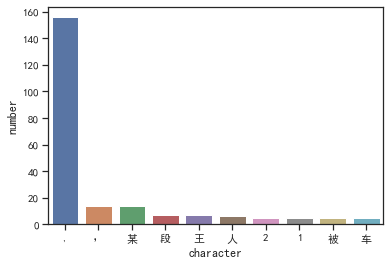

In [48]:
import seaborn as sns
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
def plot_repeat(s):
    df1=pd.DataFrame()
    character,number=[],[]
    for i in s:
        character.append(i[0])
        number.append(i[1])
    df1["character"]=character
    df1["number"]=number
    return sns.barplot(data=df1, x="character", y="number")

plot_repeat(word_counts_top)

### 计算交叉熵

In [49]:
df.head(5)

,fact,meta,text_clean,split_text
0,昌宁县人民检察院指控，2014年4月19日下午16时许，被告人段某驾拖车经过鸡飞乡澡塘街子，...,"{'relevant_articles': [234], 'accusation': ['故...",昌宁县人民检察院指控，2014年4月19日下午16时许，被告人段某驾拖车经过鸡飞乡澡塘街子，...,"昌宁县,人民检察院,指控,，,2014,年,4,月,19,日,下午,16,时许,，,被告人,..."
1,"公诉机关指控,2015年11月10日晚9时许，被告人李某的妹妹李某某与被害人华某某在桦川县悦...","{'relevant_articles': [234], 'accusation': ['故...","公诉机关指控,2015年11月10日晚9时许，被告人李某的妹妹李某某与被害人华某某在桦川县悦...","公诉,机关,指控,,,2015,年,11,月,10,日晚,9,时许,，,被告人,李某,的,妹..."
2,贵州省平坝县人民检察院指控：2014年4月9日下午，被告人王某丁与其堂哥王4某（另案处理）假...,"{'relevant_articles': [292, 234], 'accusation'...",贵州省平坝县人民检察院指控2014年4月9日下午，被告人王某丁与其堂哥王4某另案处理假释驾驶...,"贵州省,平坝县,人民检察院,指控,2014,年,4,月,9,日,下午,，,被告人,王某,丁,..."
3,经审理查明：2014年5月6日14时许，被告人叶某某驾车途径赤壁市赵李桥镇胜利街涵洞时，被在...,"{'relevant_articles': [234], 'accusation': ['故...",经审理查明2014年5月6日14时许，被告人叶某某驾车途径赤壁市赵李桥镇胜利街涵洞时，被在此...,"经,审理,查明,2014,年,5,月,6,日,14,时许,，,被告人,叶,某某,驾车,途径,..."
4,安阳县人民检察院指控：2014年4月27日上午11时许，宋某甲在安阳县吕村镇翟奇务村被告人梁...,"{'relevant_articles': [234], 'accusation': ['故...",安阳县人民检察院指控2014年4月27日上午11时许，宋某甲在安阳县吕村镇翟奇务村被告人梁某...,"安阳县,人民检察院,指控,2014,年,4,月,27,日,上午,11,时许,，,宋某,甲,在..."


### 文本熵

In [74]:
import collections  
def cross_entropy(s):
    count=[]
    res=[]
    word_counts = collections.Counter(s) 
    word_counts_top = word_counts.most_common(len(s))
    for i in word_counts_top:
        count.append(i[1])
    for i in word_counts_top:
        res.append(i[1]/(sum(count)))
    return sum(-(res*np.log2(res)))
df["cross_entropy"]=df["split_text"].apply(lambda x : cross_entropy(x))

In [76]:
df.head(5)

,fact,meta,text_clean,split_text,cross_entropy
0,昌宁县人民检察院指控，2014年4月19日下午16时许，被告人段某驾拖车经过鸡飞乡澡塘街子，...,"{'relevant_articles': [234], 'accusation': ['故...",昌宁县人民检察院指控，2014年4月19日下午16时许，被告人段某驾拖车经过鸡飞乡澡塘街子，...,"昌宁县,人民检察院,指控,，,2014,年,4,月,19,日,下午,16,时许,，,被告人,...",5.149301
1,"公诉机关指控,2015年11月10日晚9时许，被告人李某的妹妹李某某与被害人华某某在桦川县悦...","{'relevant_articles': [234], 'accusation': ['故...","公诉机关指控,2015年11月10日晚9时许，被告人李某的妹妹李某某与被害人华某某在桦川县悦...","公诉,机关,指控,,,2015,年,11,月,10,日晚,9,时许,，,被告人,李某,的,妹...",4.834264
2,贵州省平坝县人民检察院指控：2014年4月9日下午，被告人王某丁与其堂哥王4某（另案处理）假...,"{'relevant_articles': [292, 234], 'accusation'...",贵州省平坝县人民检察院指控2014年4月9日下午，被告人王某丁与其堂哥王4某另案处理假释驾驶...,"贵州省,平坝县,人民检察院,指控,2014,年,4,月,9,日,下午,，,被告人,王某,丁,...",5.395380
3,经审理查明：2014年5月6日14时许，被告人叶某某驾车途径赤壁市赵李桥镇胜利街涵洞时，被在...,"{'relevant_articles': [234], 'accusation': ['故...",经审理查明2014年5月6日14时许，被告人叶某某驾车途径赤壁市赵李桥镇胜利街涵洞时，被在此...,"经,审理,查明,2014,年,5,月,6,日,14,时许,，,被告人,叶,某某,驾车,途径,...",5.193966
4,安阳县人民检察院指控：2014年4月27日上午11时许，宋某甲在安阳县吕村镇翟奇务村被告人梁...,"{'relevant_articles': [234], 'accusation': ['故...",安阳县人民检察院指控2014年4月27日上午11时许，宋某甲在安阳县吕村镇翟奇务村被告人梁某...,"安阳县,人民检察院,指控,2014,年,4,月,27,日,上午,11,时许,，,宋某,甲,在...",5.208188
